In [2]:
import delta_sharing
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("data_sets/almost_full_data4.csv")

In [50]:
df['tmp_diff'] = df['T2_embeded_K'] - df['T1_remote_K'] 

device_conditions = df.groupby("device_id")["tmp_diff"].agg(
    has_negative=lambda x: (x < 0).any(),  # Check if any value is negative
    has_positive=lambda x: (x > 0).any(),   # Check if any value is positive
    )



devices_with_both = device_conditions[(device_conditions["has_negative"]) & (device_conditions["has_positive"])]
devices_only_heating = device_conditions[(device_conditions["has_negative"]) & ~(device_conditions["has_positive"])]
devices_only_cooling = device_conditions[(device_conditions["has_positive"]) & ~(device_conditions["has_negative"])] 


# Count the number of unique devices meeting the condition
count_both = devices_with_both.shape[0]
print(devices_with_both.shape[0])
print(devices_only_heating.shape[0])
print(devices_only_cooling.shape[0])


77
150
30


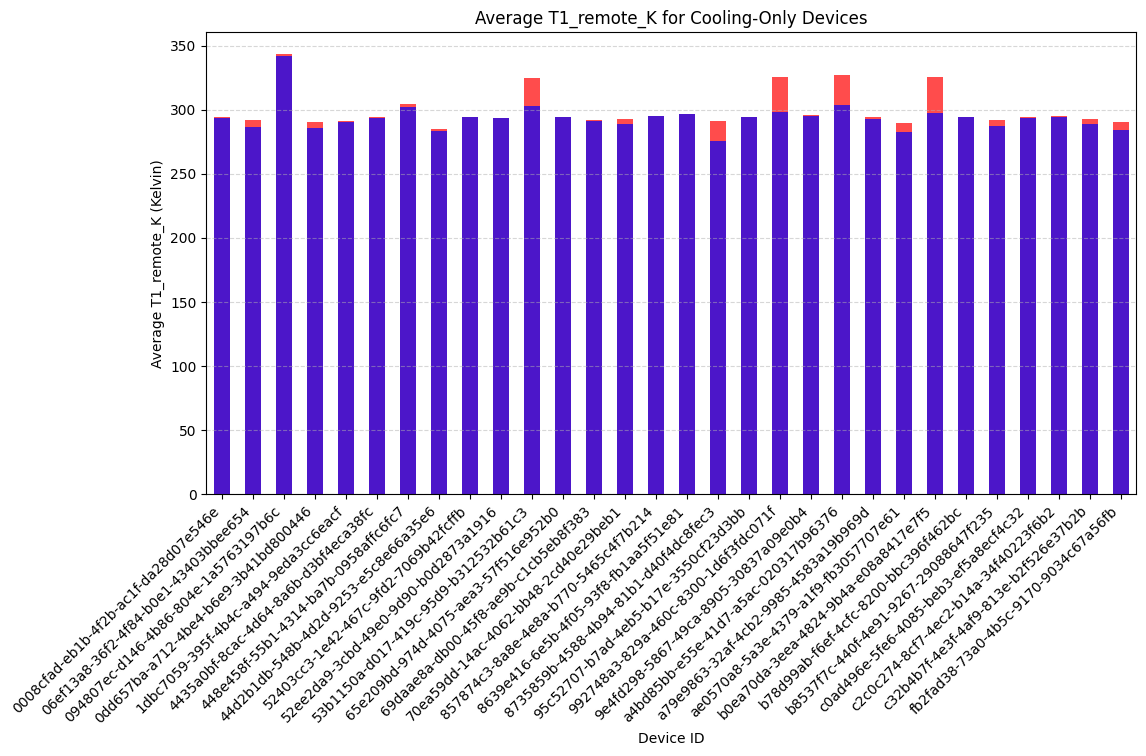

In [95]:
# List of device_ids that only cool (assuming you already have it)
cooling_device_ids = set(devices_only_cooling.index)  # Convert index to a set

# Filter df_tmp for only cooling devices
cooling_df = df[df["device_id"].isin(cooling_device_ids)]

# Compute the average T1_remote_K per device
avg_T1_remote_K = cooling_df.groupby("device_id")["T1_remote_K"].mean()
avg_T2_embeded_K = cooling_df.groupby("device_id")["T2_embeded_K"].mean()

stats_df_cooling2 =  cooling_df.groupby("device_id")["T2_embeded_K"].agg(
    mean_T2=('mean'),
    std_T2=('std'),
    var_T2=('var'),
    min_T2=('min'),
    max_T2=('max')
).reset_index()

stats_df_cooling = cooling_df.groupby("device_id")["T1_remote_K"].agg(
    mean_T1=('mean'),
    mean_T2=('mean'),
    std_T1=('std'),
    var_T1=('var'),
    min_T1=('min'),
    max_T1=('max')
).reset_index()

stats_df_cooling = stats_df_cooling.merge(stats_df_cooling2, on="device_id", how="left")



# Plot the average T1_remote_K for each cooling device
plt.figure(figsize=(12, 6))
avg_T2_embeded_K.plot(kind='bar', color='red', alpha=0.7)
avg_T1_remote_K.plot(kind='bar', color='blue', alpha=0.7)


# Customize the plot
plt.xlabel("Device ID")
plt.ylabel("Average T1_remote_K (Kelvin)")
plt.title("Average T1_remote_K for Cooling-Only Devices")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Show the plot
plt.show()

In [96]:
print(cooling_df.columns)

Index(['device_id', 'dataprofile_id', 'cloud_received_time', 'sample_time',
       'year', 'year_month', 'year_month_day',
       'influx_migration_source_filename', 'T1_remote_K', 'T2_embeded_K',
       'RelFlow_Fb_Rel2Vmax', 'RelPower_Fb_Rel2Pmax', 'AbsFlow_Fb_m3s',
       'AbsPower_Fb_W', 'Heating_E_J', 'Glycol_Concentration_Rel',
       'ControlMode_Write', 'Cooling_E_J', 'RelPos_Fb',
       'DeltaT_Limitation_Write', 'SpDeltaT_K_Write', 'Pmax_Rel_Write',
       'Vmax_Rel_Write', 'InstallationPosition_Write', 'Override_Write',
       'DN_Size', 'SpFlow_DeltaT_lmin_Write', 'DDC_Sp_Rel',
       'SpDeltaT_applied_K', 'Error_Status_Cloud', 'DDC_BUS_Sp_Write',
       'dT_Manager_Ste', 'Active_dT_Manager_total_h', 'DeltaT_K', 'DDC_Sp_V',
       'OperatingHours', 'Flow_Volume_total_m3', 'Y3AnalogInputValue',
       'tmp_diff'],
      dtype='object')


In [ ]:
#classifying cooling devices


stats_df_cooling["temperature_class"] = stats_df_cooling["mean_T1"].apply(
    lambda x: "below_310" if x <= 310 else "above_310")

print(stats_df_cooling)

                               device_id     mean_T1   mean_T2_x      std_T1  \
0   0008cfad-eb1b-4f2b-ac1f-da28d07e546e  293.739462  293.739462    0.310028   
1   06ef13a8-36f2-4f84-b0e1-43403bbee654  286.684778  286.684778    3.977640   
2   094807ec-d146-4b86-804e-1a5763197b6c  342.153498  342.153498  189.312466   
3   0dd657ba-a712-4be4-b6e9-3b41bd800446  285.468712  285.468712    0.363885   
4   1dbc7059-395f-4b4c-a494-9eda3cc6eacf  290.652094  290.652094    0.450159   
5   4435a0bf-8cac-4d64-8a6b-d3bf4eca38fc  293.900371  293.900371    0.171957   
6   448e458f-55b1-4314-ba7b-0958affc6fc7  301.908496  301.908496    2.273179   
7   44d2b1db-548b-4d2d-9253-e5c8e66a35e6  283.790570  283.790570    0.165862   
8   52403cc3-1e42-467c-9fd2-7069b42fcffb  294.075524  294.075524    0.264091   
9   52ee2da9-3cbd-49e0-9d90-b0d2873a1916  293.190009  293.190009    0.267474   
10  53b1150a-d017-419c-95d9-b312532b61c3  303.058403  303.058403    0.807033   
11  65e209bd-974d-4075-aea3-57f516e952b0

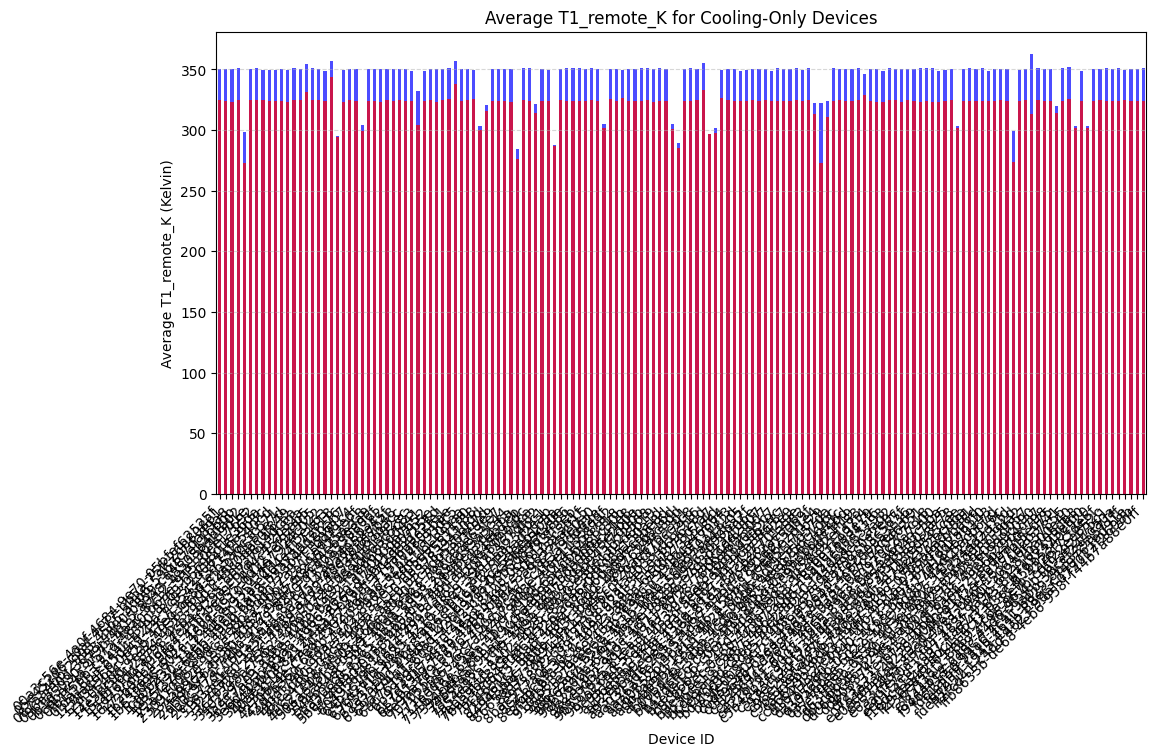

In [ ]:
# List of device_ids that only heat (assuming you already have it)
heating_device_ids = set(devices_only_heating.index)  # Convert index to a set

# Filter df_tmp for only cooling devices
heating_df = df[df["device_id"].isin(heating_device_ids)]

# Compute the average T1_remote_K per device
avg_T1_remote_K = heating_df.groupby("device_id")["T1_remote_K"].mean()
avg_T2_embeded_K = heating_df.groupby("device_id")["T2_embeded_K"].mean()

stats_df_heating2 =  heating_df.groupby("device_id")["T2_embeded_K"].agg(
    mean_T2=('mean'),
    std_T2=('std'),
    var_T2=('var'),
    min_T2=('min'),
    max_T2=('max')
).reset_index()

stats_df_heating = heating_df.groupby("device_id")["T1_remote_K"].agg(
    mean_T1=('mean'),
    std_T1=('std'),
    var_T1=('var'),
    min_T1=('min'),
    max_T1=('max')
).reset_index()

stats_df_heating = stats_df_heating.merge(stats_df_heating2, on="device_id", how="left")




# Plot the average T1_remote_K for each cooling device
plt.figure(figsize=(12, 6))

avg_T1_remote_K.plot(kind='bar', color='blue', alpha=0.7)
avg_T2_embeded_K.plot(kind='bar', color='red', alpha=0.7)



# Customize the plot
plt.xlabel("Device ID")
plt.ylabel("Average T1_remote_K (Kelvin)")
plt.title("Average T1_remote_K for Heating-Only Devices")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Show the plot
plt.show()

In [99]:
#classifying cooling devices

stats_df_heating["temperature_class"] = stats_df_heating["mean_T1"].apply(
    lambda x: "above_340" if x >= 340 else ("between_310_and_340" if x >= 310 else "below_310")
)

print(stats_df_heating)

                                device_id     mean_T1    std_T1    var_T1  \
0    00a3c56e-4a0f-4684-9e70-05bfef62525f  350.817851  0.008437  0.000071   
1    05e452d6-c0af-4c77-bb5a-75fc26b80861  350.432851  0.007706  0.000059   
2    087aa4bb-2993-45b5-adb6-5967c7da89a8  350.535009  0.006879  0.000047   
3    096a330d-3093-4890-b859-ca487e11bbbb  350.843677  0.009678  0.000094   
4    0b1d5030-879b-4b15-a048-18508b4bfa02  298.472165  0.000000  0.000000   
..                                    ...         ...       ...       ...   
145  fd61af50-94a6-4c4f-9abb-38cef244da0a  351.108824  0.009172  0.000084   
146  fd82ffff-c41b-4641-b829-8b3339a571ff  349.696687  0.005540  0.000031   
147  fde51937-1943-4a3b-88ec-c749761ad91e  350.481374  0.009960  0.000099   
148  ff2fcd41-c4dd-4623-9daf-079012f2698b  350.733660  0.014917  0.000223   
149  ffb8633b-de68-4eb6-958f-f44b7a88e0ff  351.340011  0.006494  0.000042   

         min_T1      max_T1     mean_T2    std_T2    var_T2      min_T2  \


In [100]:
# now we merge it into the initial dataset
cooling_df = cooling_df.merge(stats_df_cooling, on="device_id", how="left")
heating_df = heating_df.merge(stats_df_heating, on="device_id", how="left")
print(cooling_df.columns)
print(heating_df.columns)

#! output: cooling_df has data for all cooling devices and basic statistics on the temperature
#! same for heating_df

Index(['device_id', 'dataprofile_id', 'cloud_received_time', 'sample_time',
       'year', 'year_month', 'year_month_day',
       'influx_migration_source_filename', 'T1_remote_K', 'T2_embeded_K',
       'RelFlow_Fb_Rel2Vmax', 'RelPower_Fb_Rel2Pmax', 'AbsFlow_Fb_m3s',
       'AbsPower_Fb_W', 'Heating_E_J', 'Glycol_Concentration_Rel',
       'ControlMode_Write', 'Cooling_E_J', 'RelPos_Fb',
       'DeltaT_Limitation_Write', 'SpDeltaT_K_Write', 'Pmax_Rel_Write',
       'Vmax_Rel_Write', 'InstallationPosition_Write', 'Override_Write',
       'DN_Size', 'SpFlow_DeltaT_lmin_Write', 'DDC_Sp_Rel',
       'SpDeltaT_applied_K', 'Error_Status_Cloud', 'DDC_BUS_Sp_Write',
       'dT_Manager_Ste', 'Active_dT_Manager_total_h', 'DeltaT_K', 'DDC_Sp_V',
       'OperatingHours', 'Flow_Volume_total_m3', 'Y3AnalogInputValue',
       'tmp_diff', 'mean_T1', 'mean_T2_x', 'std_T1', 'var_T1', 'min_T1',
       'max_T1', 'mean_T2_y', 'std_T2', 'var_T2', 'min_T2', 'max_T2',
       'temperature_class'],
      dtype

In [101]:
print(cooling_df)

                                   device_id     dataprofile_id  \
0       8735859b-4588-4b94-81b1-d40f4dc8fec3  energyvalve3/1.11   
1       8735859b-4588-4b94-81b1-d40f4dc8fec3  energyvalve3/1.11   
2       8735859b-4588-4b94-81b1-d40f4dc8fec3  energyvalve3/1.11   
3       8735859b-4588-4b94-81b1-d40f4dc8fec3  energyvalve3/1.11   
4       8735859b-4588-4b94-81b1-d40f4dc8fec3  energyvalve3/1.11   
...                                      ...                ...   
538555  ae0570a8-5a3e-4379-a1f9-fb3057707e61  energyvalve3/1.11   
538556  ae0570a8-5a3e-4379-a1f9-fb3057707e61  energyvalve3/1.11   
538557  ae0570a8-5a3e-4379-a1f9-fb3057707e61  energyvalve3/1.11   
538558  ae0570a8-5a3e-4379-a1f9-fb3057707e61  energyvalve3/1.11   
538559  ae0570a8-5a3e-4379-a1f9-fb3057707e61  energyvalve3/1.11   

                     cloud_received_time                       sample_time  \
0       2019-06-10 09:13:22.040000+00:00  2019-06-10 09:13:20.371000+00:00   
1       2019-06-13 21:50:34.473000+00:0

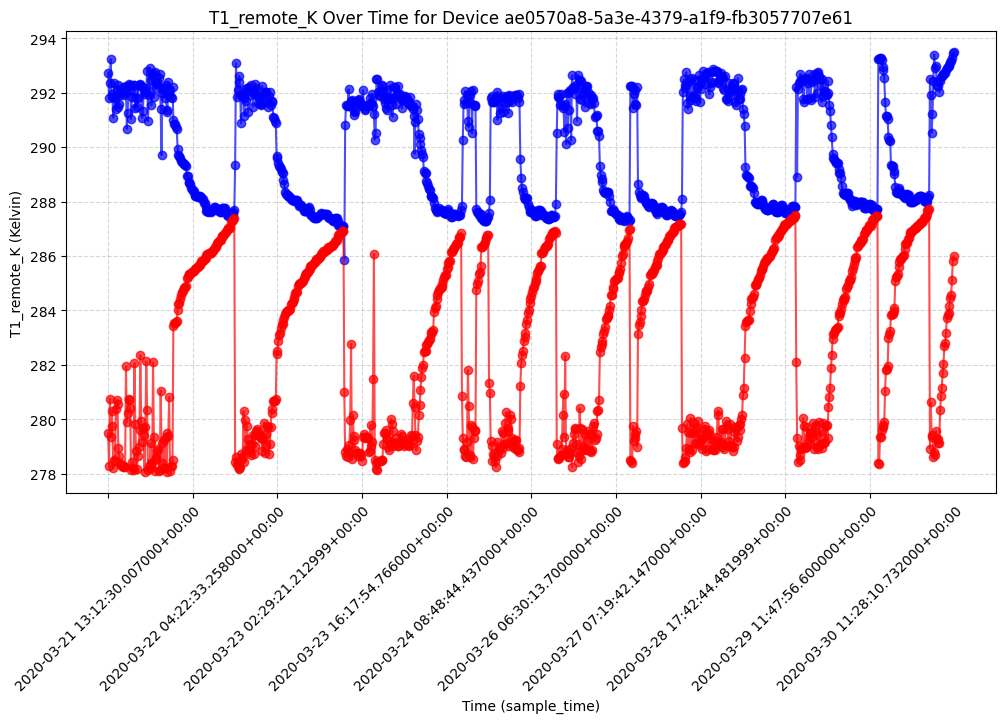

In [113]:
device_id_to_plot = "ae0570a8-5a3e-4379-a1f9-fb3057707e61"  # Replace with the actual device_id
device_df = cooling_df[cooling_df['device_id'] == device_id_to_plot]

device_df = device_df.sample(1000).sort_values('sample_time')

# print(device_df)


plt.figure(figsize=(12, 6))
plt.plot(device_df["sample_time"], device_df["T2_embeded_K"], marker="o", linestyle="-", color="b", alpha=0.7)

plt.plot(device_df["sample_time"], device_df["T1_remote_K"], marker="o", linestyle="-", color="r", alpha=0.7)

# Customize the plot
plt.xlabel("Time (sample_time)")
plt.ylabel("T1_remote_K (Kelvin)")
plt.title(f"T1_remote_K Over Time for Device {device_id_to_plot}")
xticks = device_df["sample_time"].iloc[::100]  # Select every 100th timestamp
plt.xticks(xticks, rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)

# Show the plot
plt.show()
